In [1]:
# Reference: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#from torch.utils.tensorboard import SummaryWriter

import argparse
from distutils.util import strtobool
import collections
import numpy as np
import gym
from gym.wrappers import TimeLimit, Monitor
from gym.spaces import Discrete, Box, MultiBinary, MultiDiscrete, Space
import time
import random
import os
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [2]:
# TRY NOT TO MODIFY: seeding
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env = gym.make('Humanoid-v2')
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

# Hyper params
#discrete_action_space_dim = 101
discrete_action_space_dim = 21
input_dim = env.observation_space.shape[0]
#hidden_dim = 765
hidden_dim = 765
output_dim = env.action_space.shape[0] * discrete_action_space_dim
#output_dim = train_env.action_space.shape[0]
print (input_dim, output_dim)

/home/gswatiseas/gym/gym/envs/registration.py:579: UserWarning: WARN: The environment Humanoid-v2 is out of date. You should consider upgrading to version v3 with the environment ID `Humanoid-v3`.
  f"The environment {spec.id} is out of date. You should consider "


376 357


In [3]:
# modified from https://github.com/seungeunrho/minimalRL/blob/master/dqn.py#
class ReplayBuffer():
    def __init__(self, buffer_limit):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        #print ("transition: ", len(transition))
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r)
            s_prime_lst.append(s_prime)
            done_mask_lst.append(done_mask)

        return np.array(s_lst), np.array(a_lst), \
               np.array(r_lst), np.array(s_prime_lst), \
               np.array(done_mask_lst)
    def flush(self):
        self.buffer.clear()
        
    def len(self):
        return (len(self.buffer))
        

# ALGO LOGIC: initialize agent here:
class QNetwork(nn.Module):
    def __init__(self, env):
        super(QNetwork, self).__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_1a = nn.Linear(hidden_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.maxpool = nn.MaxPool1d(discrete_action_space_dim, stride=discrete_action_space_dim, return_indices=True)

    def forward(self, x, device):
        x = torch.FloatTensor(x).to(device)
        x = torch.tanh(self.fc_1(x))
        x = torch.tanh(self.fc_1a(x))
        x = self.fc_2(x)
        x1, indices = self.maxpool(x)
        return x1, indices

def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope =  (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)


In [4]:
n = discrete_action_space_dim
max_action = 0.4
min_action = -0.4
inc = (max_action - min_action)/ (n-1)
print (inc)
discrete_action_list = [min_action+inc*i for i in range(0, n)]
print (len(discrete_action_list))

0.04
21


In [5]:
def get_actions(action_indices):
    ret_actions = np.zeros(env.action_space.shape[0])
    for i in range(0, len(action_indices)):
        index = action_indices[i] - i*discrete_action_space_dim
        ret_actions[i] = discrete_action_list[index]
    return ret_actions

In [6]:
buffer_size = 100_000
lr = 7.5e-4

rb = ReplayBuffer(buffer_size)
q_network = QNetwork(env).to(device)
target_network = QNetwork(env).to(device)
target_network.load_state_dict(q_network.state_dict())

optimizer = optim.RMSprop(q_network.parameters(), lr=lr)
#optimizer = optim.Adam(q_network.parameters(), lr=lr)
#loss_fn = nn.MSELoss()
print(device.__repr__())
print(q_network)
exploration_fraction = 0.5
target_network_frequency = 100
batch_size = 10
max_grad_norm = 1.0
gamma = 0.99


# Hyper params
n_iters = 30
steps_per_iter = 4000
phase = 'train'
max_step = 1000

device(type='cuda')
QNetwork(
  (fc_1): Linear(in_features=376, out_features=765, bias=True)
  (fc_1a): Linear(in_features=765, out_features=765, bias=True)
  (fc_2): Linear(in_features=765, out_features=357, bias=True)
  (maxpool): MaxPool1d(kernel_size=21, stride=21, padding=0, dilation=1, ceil_mode=False)
)


In [15]:
def agent_run(max_steps, global_step, epsilon, eval_mode):
    obs = env.reset()
    episode_reward = 0
    episode = 0
    step_count = 0

    for steps in range(max_steps):

        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_vals, action_indices = q_network.forward(obs[None, :], device)
            action = get_actions(action_indices.view((-1)))
            
        next_obs, reward, done, _ = env.step(action)
        episode_reward += reward

        rb.put((obs, action, reward, next_obs, done))

        if steps -  batch_size > 0:
            s_obs, s_actions, s_rewards, s_next_obses, s_dones = rb.sample(batch_size)
            with torch.no_grad():
                q_next_val, action_next_indices = target_network.forward(s_next_obses, device)
                target_max = q_next_val.sum()
                td_target = torch.Tensor(s_rewards).to(device) + gamma * target_max * (1 - torch.Tensor(s_dones).to(device))

            old_q, old_action = q_network.forward(s_obs, device)
            loss = F.smooth_l1_loss(td_target, torch.sum(old_q, 1))

            # optimize the model
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(list(q_network.parameters()), max_grad_norm)
            optimizer.step()

        # update the target network
        if global_step % target_network_frequency == 0 and eval_mode==False:
            target_network.load_state_dict(q_network.state_dict())

        # TRY NOT TO MODIFY: CRUCIAL step easy to overlook 
        obs = next_obs
        step_count+=1

        if done:
            break
    return step_count, episode_reward
      

In [16]:
start_time = time.time()

total_num_steps = 0
train_sum_returns = 0.
train_num_episodes = 0
eval_mode = False

train_avg_ret = []
train_ep_ret = []
eval_avg_ret = []
eval_ep_ret = []
epsilon = 0.9
decay_rate = 0.995

for i in range(n_iters):
        # Perform the training phase, during which the agent learns
        if phase == 'train':
            train_step_count = 0
            while train_step_count <= steps_per_iter:
                eval_mode = False
                epsilon = max(epsilon*decay_rate, 0.1)
                
                # Run one episode
                train_step_length, train_episode_return = agent_run(max_step, i, epsilon, eval_mode)
                
                total_num_steps += train_step_length
                train_step_count += train_step_length
                train_sum_returns += train_episode_return
                train_num_episodes += 1

                train_average_return = train_sum_returns / train_num_episodes if train_num_episodes > 0 else 0.0
                
                train_avg_ret.append(train_average_return)
                train_ep_ret.append(train_episode_return)


        # Perform the evaluation phase -- no learning
        eval_sum_returns = 0.
        eval_num_episodes = 0
        eval_mode = True

        for _ in range(10):
            # Run one episode
            eval_step_length, eval_episode_return = agent_run(max_step, i, 0, eval_mode)

            eval_sum_returns += eval_episode_return
            eval_num_episodes += 1

        eval_average_return = eval_sum_returns / eval_num_episodes if eval_num_episodes > 0 else 0.0
        eval_avg_ret.append(eval_average_return)
        eval_ep_ret.append(eval_episode_return)


        if phase == 'train':
            print('---------------------------------------')
            print('Iterations:', i + 1)
            print('Steps:', total_num_steps)
            print('Episodes:', train_num_episodes)
            print('EpisodeReturn:', round(train_episode_return, 2))
            print('AverageReturn:', round(train_average_return, 2))
            print('EvalEpisodes:', eval_num_episodes)
            print('EvalEpisodeReturn:', round(eval_episode_return, 2))
            print('EvalAverageReturn:', round(eval_average_return, 2))
            print('Time:', int(time.time() - start_time))
            print('---------------------------------------')
        else:
            print('---------------------------------------')
            print('EvalEpisodes:', eval_num_episodes)
            print('EvalEpisodeReturn:', round(eval_episode_return, 2))
            print('EvalAverageReturn:', round(eval_average_return, 2))
            print('Time:', int(time.time() - start_time))
            print('---------------------------------------')
            

---------------------------------------
Iterations: 1
Steps: 4019
Episodes: 128
EpisodeReturn: 151.24
AverageReturn: 158.14
EvalEpisodes: 10
EvalEpisodeReturn: 180.36
EvalAverageReturn: 177.11
Time: 15
---------------------------------------
---------------------------------------
Iterations: 2
Steps: 8048
Episodes: 228
EpisodeReturn: 210.67
AverageReturn: 176.86
EvalEpisodes: 10
EvalEpisodeReturn: 175.81
EvalAverageReturn: 181.54
Time: 37
---------------------------------------
---------------------------------------
Iterations: 3
Steps: 12052
Episodes: 329
EpisodeReturn: 171.42
AverageReturn: 182.53
EvalEpisodes: 10
EvalEpisodeReturn: 183.93
EvalAverageReturn: 180.59
Time: 61
---------------------------------------
---------------------------------------
Iterations: 4
Steps: 16074
Episodes: 432
EpisodeReturn: 185.46
AverageReturn: 184.93
EvalEpisodes: 10
EvalEpisodeReturn: 171.01
EvalAverageReturn: 180.2
Time: 86
---------------------------------------
-------------------------------

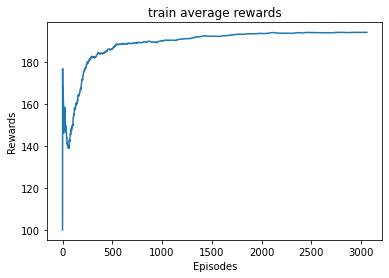

Text(0.5, 1.0, 'train episode rewards')

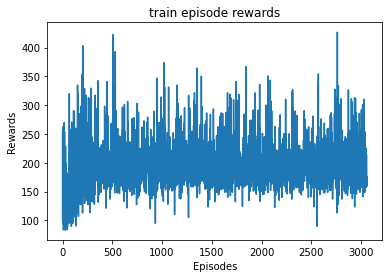

In [17]:
plt.show()
plt.plot(train_avg_ret)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("train average rewards")

plt.show()
plt.plot(train_ep_ret)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("train episode rewards")

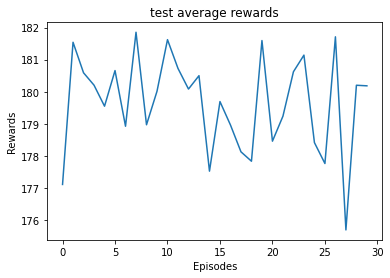

Text(0.5, 1.0, 'test episode rewards')

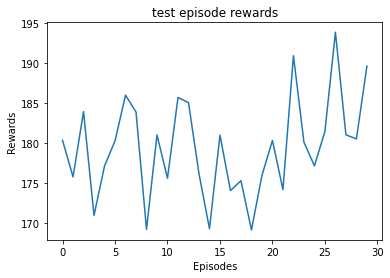

In [18]:
plt.show()
plt.plot(eval_avg_ret)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("test average rewards")

plt.show()
plt.plot(eval_ep_ret)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("test episode rewards")